### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import KFold, cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


VERBOSE = 1
CV = 4#[(slice(None), slice(None))]
TESTING = False

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-23 11:24:59.406932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 11:25:00.654469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
ITER = 6

hyperparameterspace = {
    'epochs': ["interval-int", 1, 30],
    #'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.1],
    #'model__neurons_per_layer': ["interval-int", 1, 100],
    #'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

######################################################################################################################################################
Current Dataset: 1 of 5 with id: 233214

################################################## Current Budget: 1 ##################################################
Performing grid search
Fitting 4 folds for each of 1 candidates, totalling 4 fits


2023-04-23 11:25:06.481521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Best params found by grid search:
{'epochs': 15, 'optimizer__learning_rate': 9.999999999999991e-05}
Performing random search
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best params found by random search:
{'epochs': 5, 'optimizer__learning_rate': 0.033804944708180504}
Performing bayesian optimization
Iterations took 24.377884741988964 seconds
With Hyperparameters: 
epochs: 5.426892096572803
optimizer__learning_rate: 0.08862370368942236
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 18040ms.


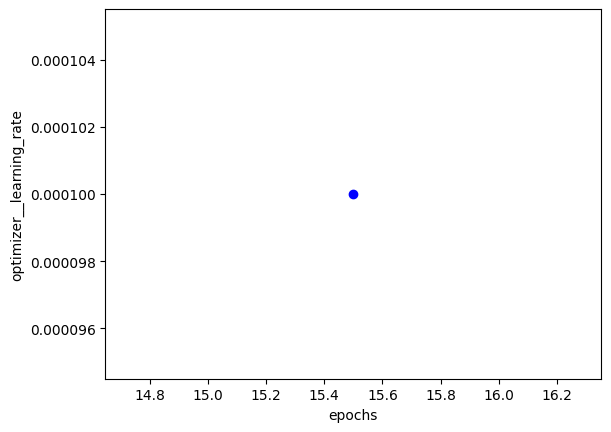

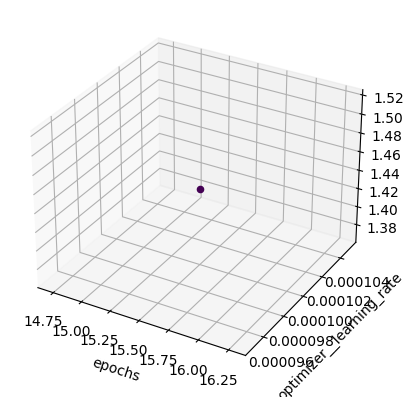

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
1.4428842779800368
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
1.4428842779800368
Resulting loss (Optimal point evaluated):
1.171418761340762
[1.2010441]
[0.9188644]
[1.0324569457067232]
[1.3207069519663426]
[1.3822380191299461]

################################################## Current Budget: 4 ##################################################
Performing grid search
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best params found by grid search:
{'epochs': 8, 'optimizer__learning_rate': 0.10000000000000006}
Performing random search
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best params found by random search:
{'epochs': 6, 'optimizer

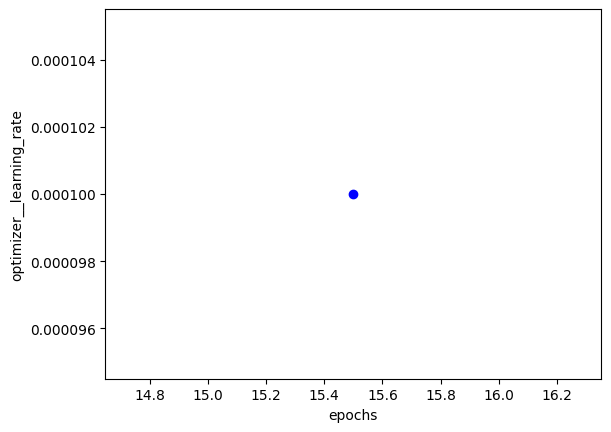

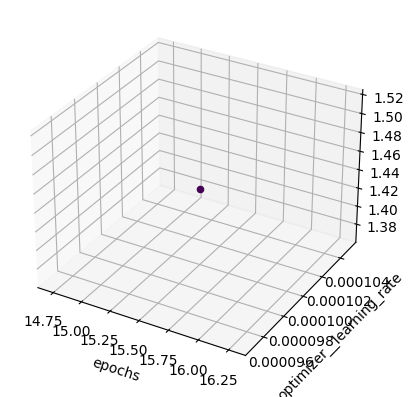

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
1.4423359347331384
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
1.4423359347331384
Resulting loss (Optimal point evaluated):
1.2262990367365736
[1.2010441, 0.9886062]
[0.9188644, 1.0458525]
[1.0324569457067232, 1.026758188264476]
[1.3207069519663426, 1.2948036878351983]
[1.3822380191299461, 1.3262598033430162]

################################################## Current Budget: 9 ##################################################
Performing grid search
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best params found by grid search:
{'epochs': 5, 'optimizer__learning_rate': 0.10000000000000006}
Performing random search
Fitting 4 folds for each of 9 candidat

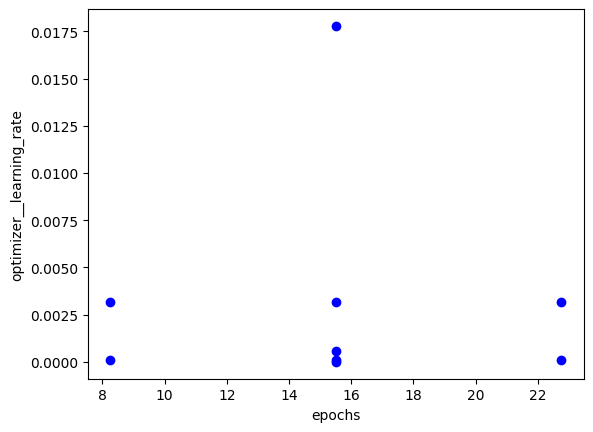

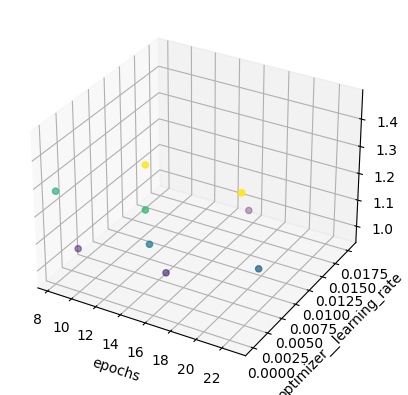

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 0.017782794100389226
Resulting loss:
0.9732610292193677
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 0.017782794100389226
Resulting loss (Optimal value from optimization):
0.9232557263154964
Resulting loss (Optimal point evaluated):
0.9903177643839042
[1.2010441, 0.9886062, 1.1089722]
[0.9188644, 1.0458525, 1.1112915]
[1.0324569457067232, 1.026758188264476, 4.774878213881888]
[1.3207069519663426, 1.2948036878351983, 1.0237794056521983]
[1.3822380191299461, 1.3262598033430162, 1.060008789436935]

################################################## Current Budget: 16 ##################################################
Performing grid search
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best params found by grid search:
{'epochs': 4, 'optimizer__learning_rate': 0.10

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 349.8229016249825 seconds
With Hyperparameters: 
epochs: 29.086445547466713
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 209468ms.


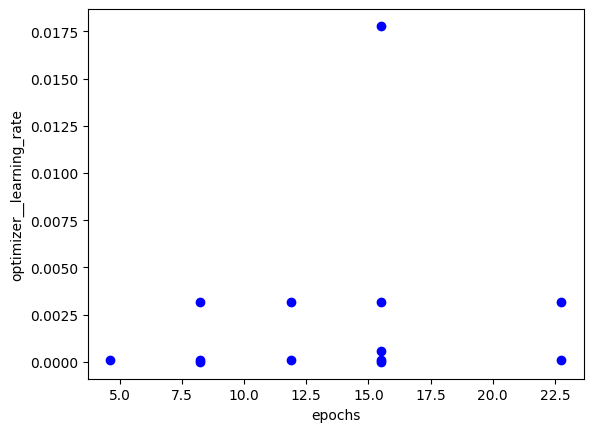

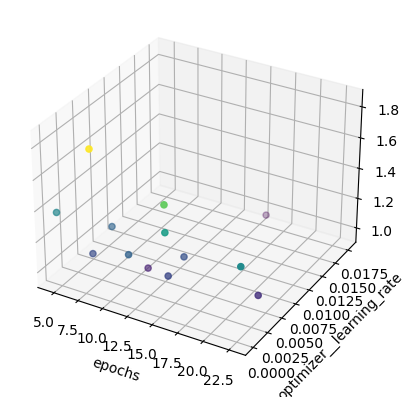

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 0.017782794100389226
Resulting loss:
0.9665129491771026
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 0.017782794100389226
Resulting loss (Optimal value from optimization):
0.7385850799544897
Resulting loss (Optimal point evaluated):
1.0132650581005458
[1.2010441, 0.9886062, 1.1089722, 1.0502373]
[0.9188644, 1.0458525, 1.1112915, 1.035921]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944]
[1.3207069519663426, 1.2948036878351983, 1.0237794056521983, 1.0794748919942319]
[1.3822380191299461, 1.3262598033430162, 1.060008789436935, 1.1304007685387751]

################################################## Current Budget: 25 ##################################################
Performing grid search
Fitting 4 folds for each of 25 candidates, totalling 100 fit

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 464.09022983614705 seconds
With Hyperparameters: 
epochs: 14.050610492496572
optimizer__learning_rate: 0.09631943828631549
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 454981ms.


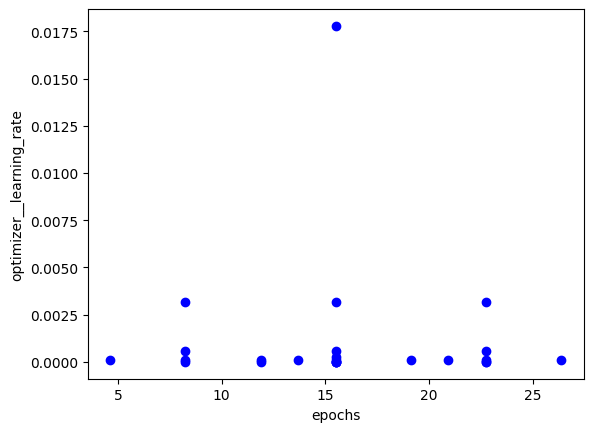

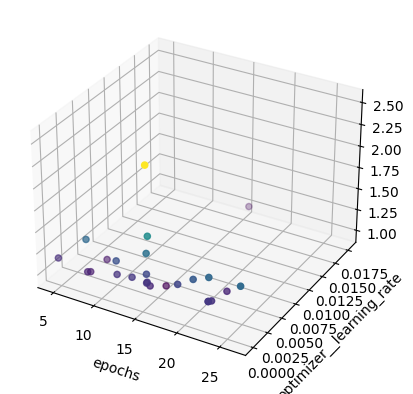

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.9679938833726937
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.9679938833726937
Resulting loss (Optimal point evaluated):
1.0925200457837174
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972]
[1.3207069519663426, 1.2948036878351983, 1.0237794056521983, 1.0794748919942319, 1.1635819810715264]
[1.3822380191299461, 1.3262598033430162, 1.060008789436935, 1.1304007685387751, 1.006183602958693]

################################################## Current Budget: 36 ##################################################
Pe

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 746.7751666390395 seconds
With Hyperparameters: 
epochs: 27.421122627592457
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 570117ms.


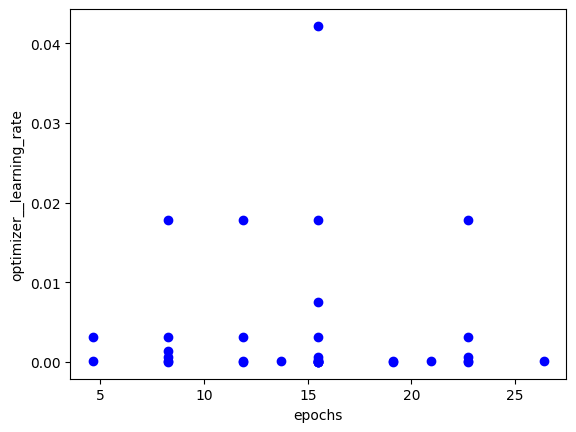

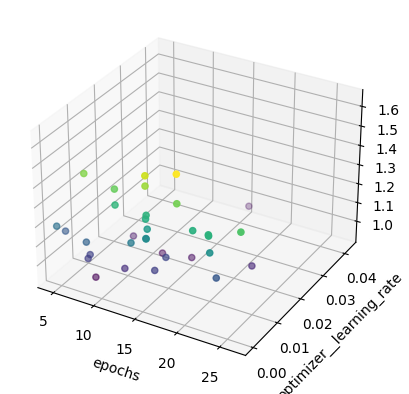

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 8.25
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.9370399255519426
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 8.25
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.9370399255519426
Resulting loss (Optimal point evaluated):
1.0521663782576616
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272]
[1.3207069519663426, 1.2948036878351983, 1.0237794056521983, 1.0794748919942319, 1.1635819810715264, 0.950546738127852]
[1.3822380191299461, 1.3262598033430162, 1.060008789436935, 1.1304007685387751, 1.006183602958693, 1.140351223369606]
############################################

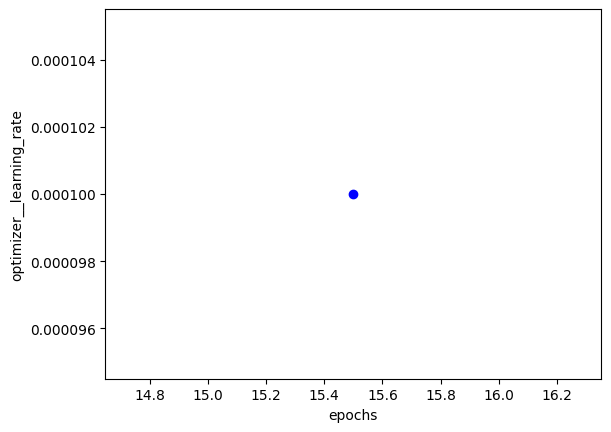

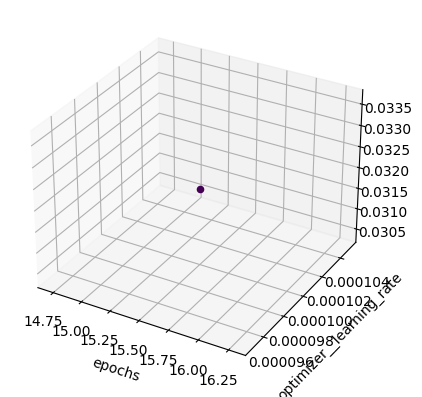

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
0.032002500424264904
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
0.032002500424264904
Resulting loss (Optimal point evaluated):
0.027734928598517904
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806]
[1.3207069519663426, 1.2948036878351983, 1.0237794056521983, 1.0794748919942319, 1.1635819810715264, 0.950546738127852, 0.033032461890783994]
[1.3822380191299461, 1.3262598033430162, 1.060008789436935, 1.1304007685387751, 1.006

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 391.8989707569999 seconds
With Hyperparameters: 
epochs: 14.256868092147062
optimizer__learning_rate: 0.06034430276545507
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 78950ms.


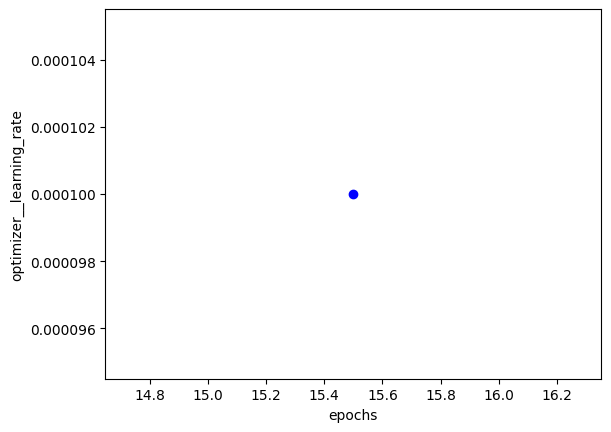

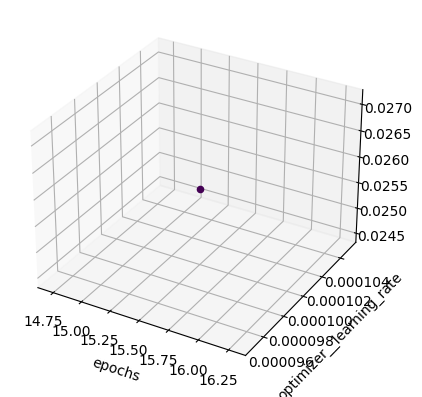

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
0.02579567445731524
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
0.02579567445731524
Resulting loss (Optimal point evaluated):
0.0292144693199023
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233]
[1.3207069519663426, 1.2948036878351983, 1.0237794056521983, 1.0794748919942319, 1.1635819810715264, 0.950546738127852, 0.033032461890783994, 0.026828461815664464]
[1.3822380191299461, 1

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 639.9772083320422 seconds
With Hyperparameters: 
epochs: 15.223500621315363
optimizer__learning_rate: 0.09212617499312256
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 862275ms.


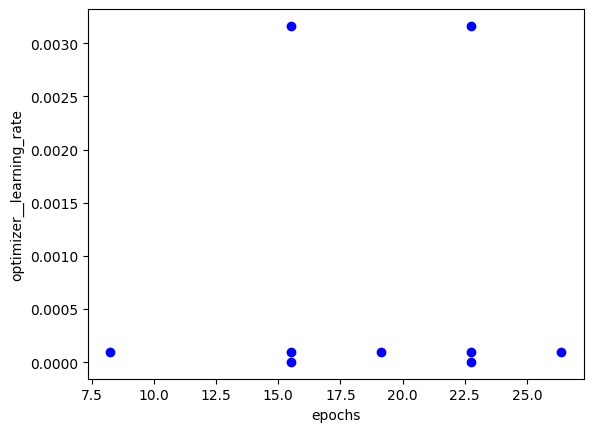

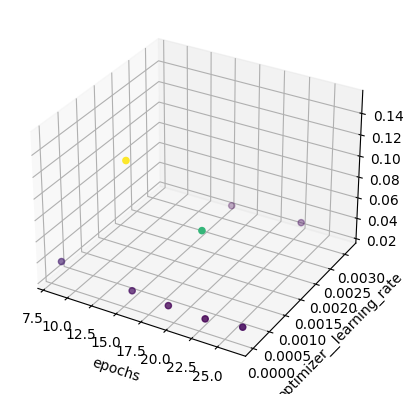

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 22.75
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
0.024857289160767265
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 22.75
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
0.024857289160767265
Resulting loss (Optimal point evaluated):
0.02875399711853225
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233, 1.0055207166017492]
[1.3207069519663426, 1.2948036878351983, 1.0237794056521983, 1.0794748919942319, 1.1635819810715264, 0.950546738127852, 0.0330324618907

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 1166.5093359829043 seconds
With Hyperparameters: 
epochs: 6.00331672265844
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 1183407ms.


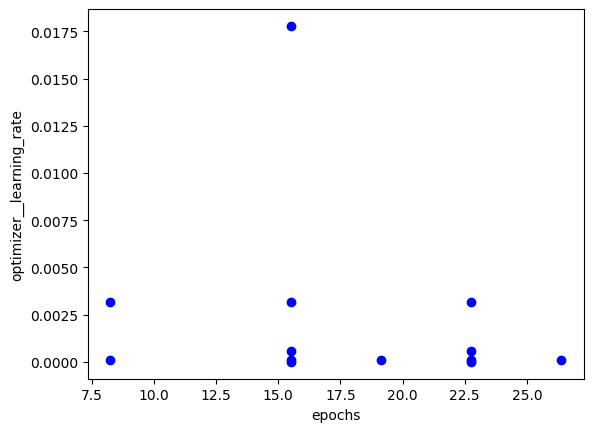

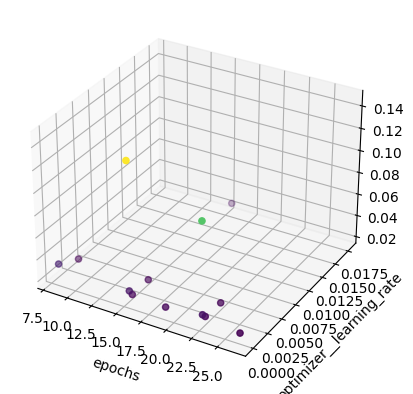

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 8.25
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.022734264650621644
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.000022768704495
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.013633504281697502
Resulting loss (Optimal point evaluated):
0.4204404276078013
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233, 1.0055207166017492, 1.0509900948435513]
[1.3207069519663426, 1.2948036878351983, 1.0237794056521983, 1.0794748919942319, 1

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 1909.8269639638602 seconds
With Hyperparameters: 
epochs: 8.691000467327303
optimizer__learning_rate: 0.09819783801215613
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 1998215ms.


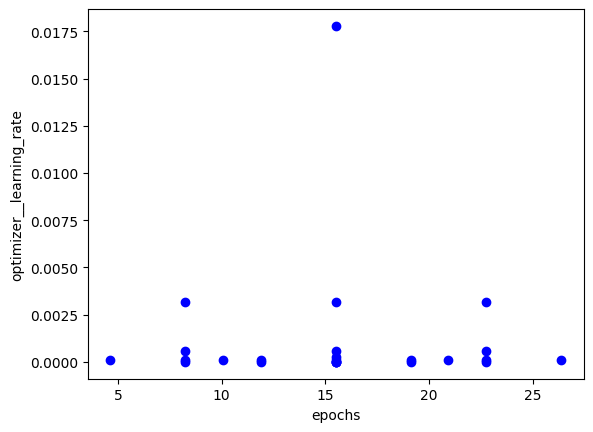

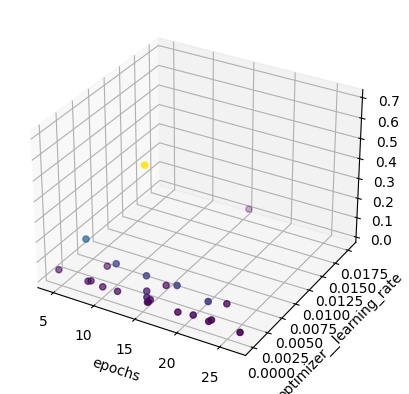

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 22.75
optimizer__learning_rate: 0.0005623413251903491
Resulting loss:
0.02136632435457049
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 22.75
optimizer__learning_rate: 0.0005623413251903491
Resulting loss (Optimal value from optimization):
0.02136632435457049
Resulting loss (Optimal point evaluated):
0.020262051147125017
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233, 1.0055207166017492, 1.0509900948435513, 0.5314248458658408]
[1.3207069519663426, 1.2948036878351983, 1.02

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 2691.1638296041056 seconds
With Hyperparameters: 
epochs: 6.4068167654176476
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 2761484ms.


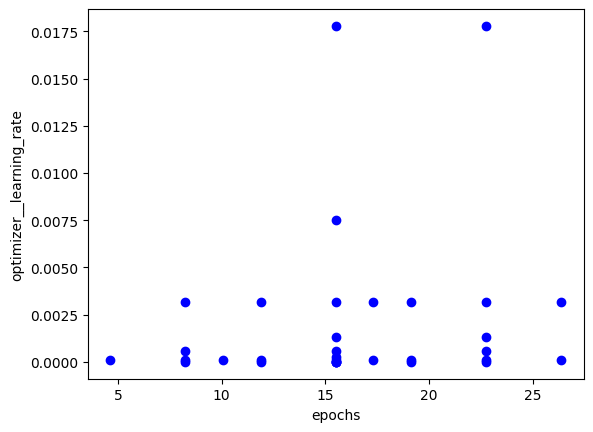

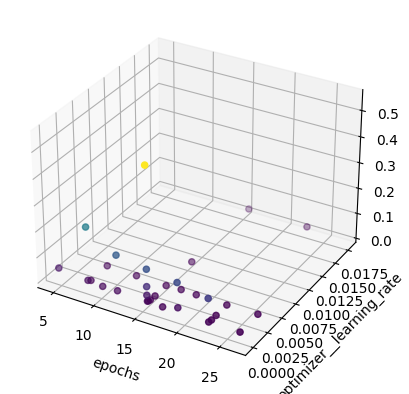

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 22.75
optimizer__learning_rate: 0.0005623413251903491
Resulting loss:
0.02139996435692651
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 22.75
optimizer__learning_rate: 0.0005623413251903491
Resulting loss (Optimal value from optimization):
0.02139996435692651
Resulting loss (Optimal point evaluated):
0.022475268739759798
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233, 1.0055207166017492, 1.0509900948435513, 0.5314248458658408, 1.1054216450009653]

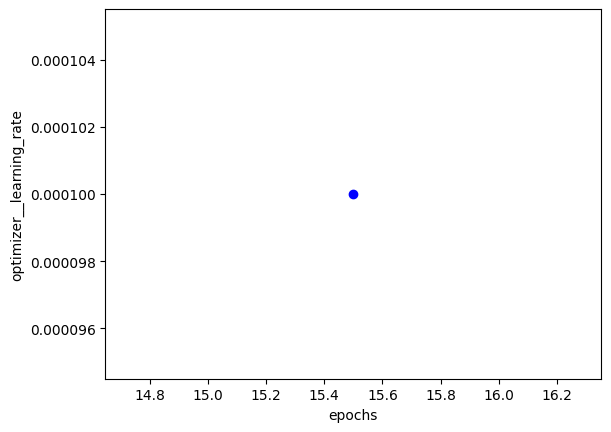

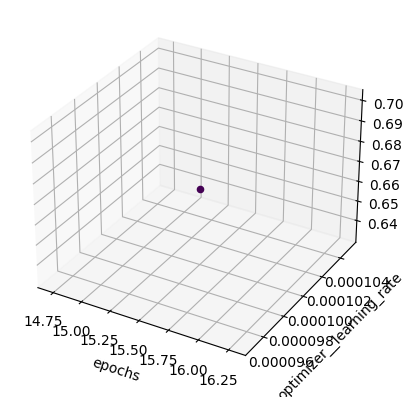

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
0.6669210849009651
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
0.6669210849009651
Resulting loss (Optimal point evaluated):
0.6644100038918961
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233, 1.0055207166017492, 1.0509900948435513, 0.5314248458658408, 1.10

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 37.379607837996446 seconds
With Hyperparameters: 
epochs: 22.530742298953417
optimizer__learning_rate: 0.04709352560598094
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 11557ms.


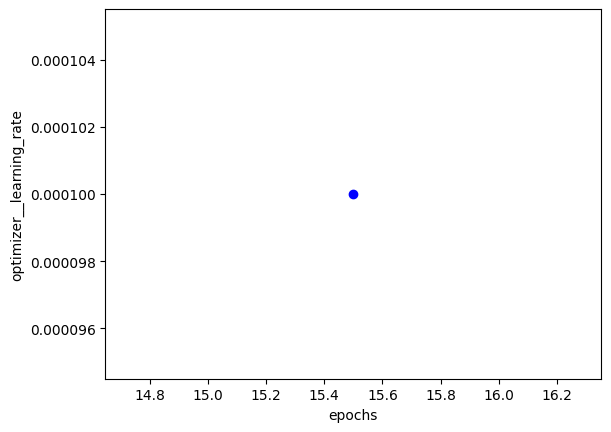

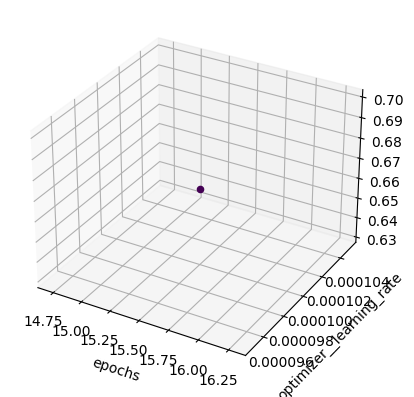

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
0.6653814631079822
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
0.6653814631079822
Resulting loss (Optimal point evaluated):
0.6621079108296246
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233, 1.0055207166017492, 1.0509900948435513, 0

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 146.08772907900857 seconds
With Hyperparameters: 
epochs: 25.56610659264952
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 102759ms.


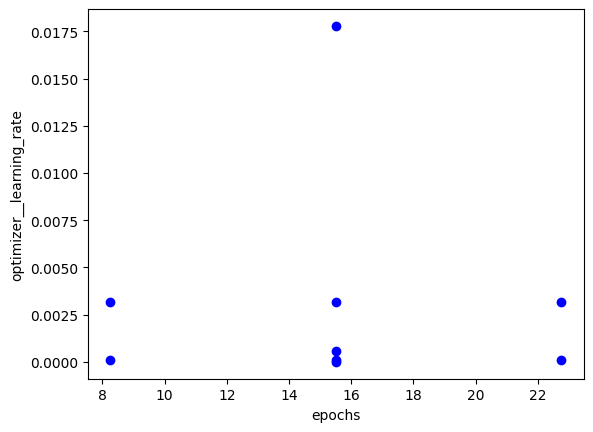

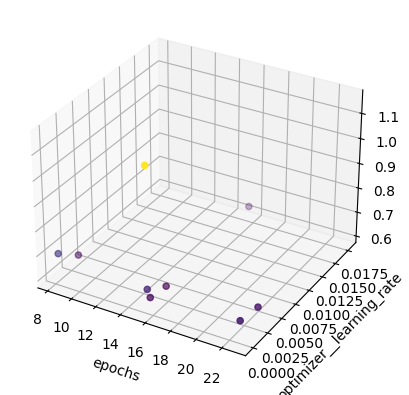

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.6119278463275079
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.6119278463275079
Resulting loss (Optimal point evaluated):
0.6268767155229101
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233, 1.0055207166017492, 1.

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 198.53694547590567 seconds
With Hyperparameters: 
epochs: 11.808397059063145
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 166257ms.


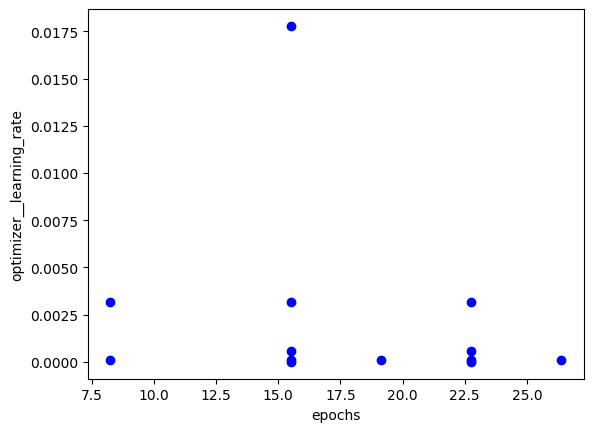

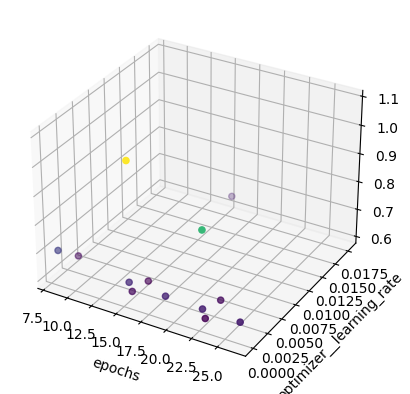

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.6101192487842949
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.6101192487842949
Resulting loss (Optimal point evaluated):
0.6103295278988019
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233,

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 289.2799872367759 seconds
With Hyperparameters: 
epochs: 18.22154807980496
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 282344ms.


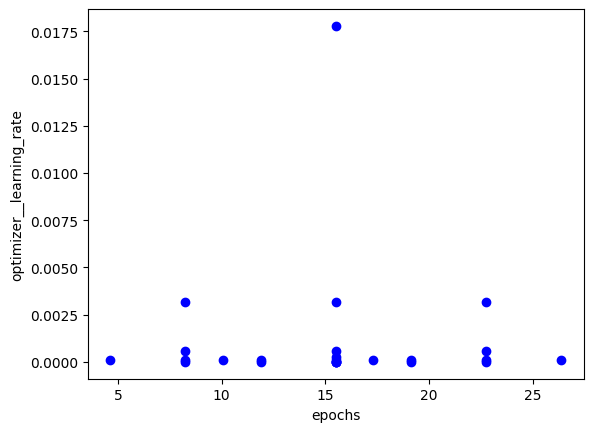

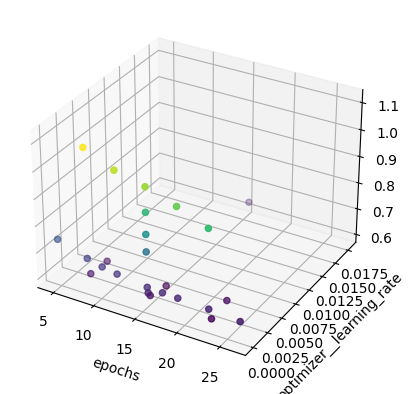

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.6060002726381722
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.6060002726381722
Resulting loss (Optimal point evaluated):
0.6176395456946486
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.0432812437669580

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 510.5858088101959 seconds
With Hyperparameters: 
epochs: 29.13881601029501
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 373463ms.


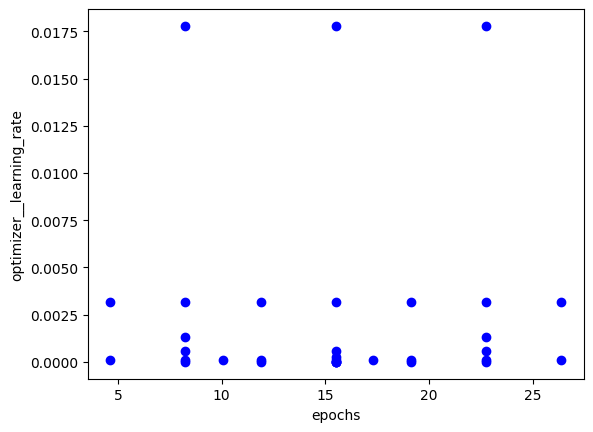

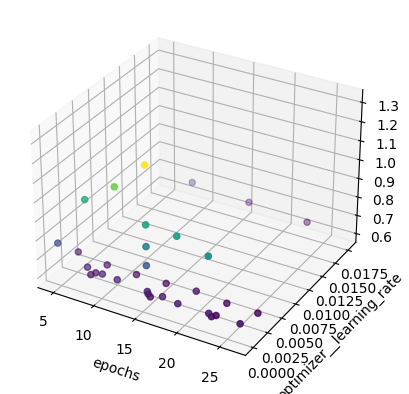

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 22.75
optimizer__learning_rate: 0.001333521432163324
Resulting loss:
0.603462372006565
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 22.75
optimizer__learning_rate: 0.001333521432163324
Resulting loss (Optimal value from optimization):
0.603462372006565
Resulting loss (Optimal point evaluated):
0.6111876448543512
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505

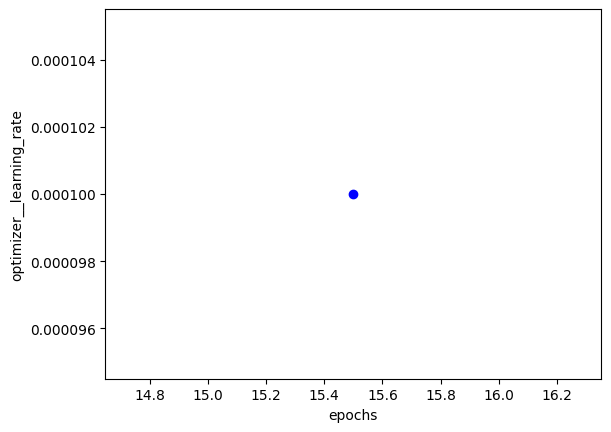

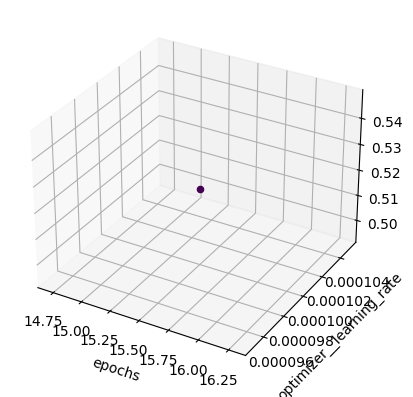

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
0.520982526717201
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
0.520982526717201
Resulting loss (Optimal point evaluated):
0.5285301135210203
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 130.56961425900226 seconds
With Hyperparameters: 
epochs: 5.025046670043979
optimizer__learning_rate: 0.06435062775611715
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 34903ms.


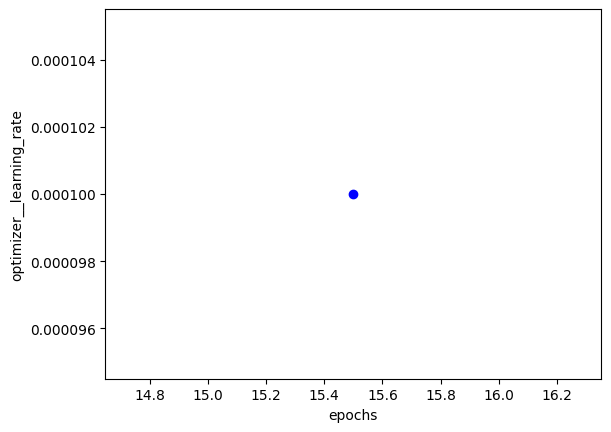

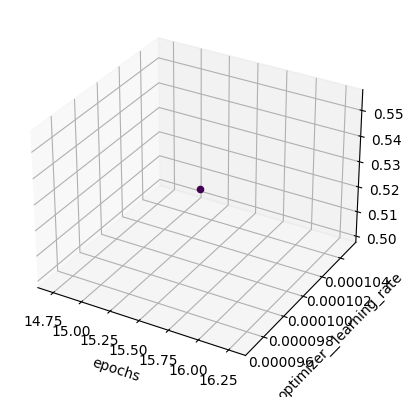

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
0.5276860238395343
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
0.5276860238395343
Resulting loss (Optimal point evaluated):
0.5224445564908101
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098, 0.3542125]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.86732

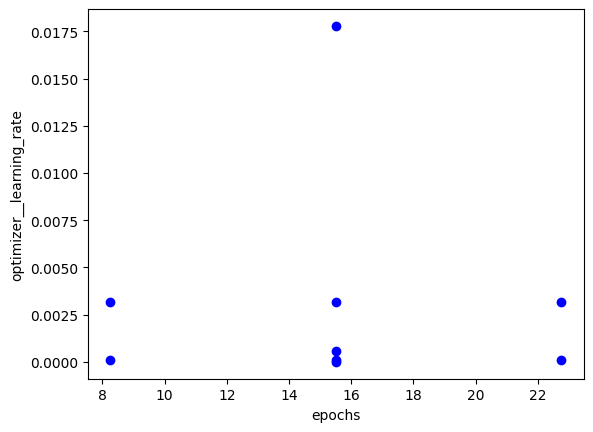

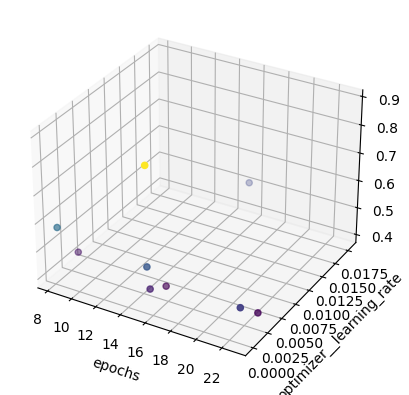

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.40491101394850654
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.40491101394850654
Resulting loss (Optimal point evaluated):
0.414304706196918
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098, 0.3542125, 0.38245776]
[1.0324569457067232, 1.026758188264476, 4.7

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 618.2048975218204 seconds
With Hyperparameters: 
epochs: 9.756829404772896
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 519400ms.


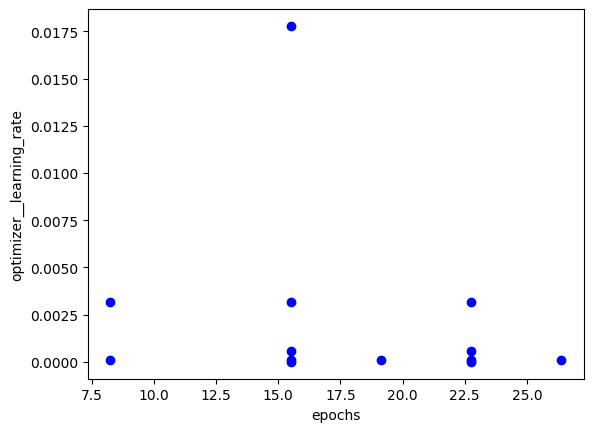

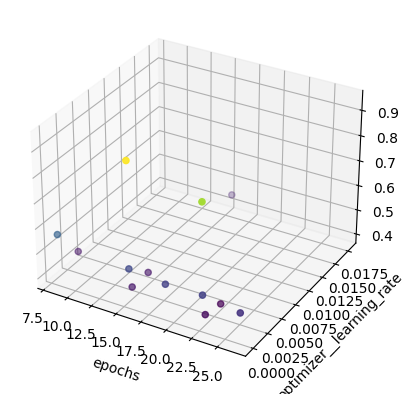

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 22.75
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.4012160122350757
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 29.99998165187893
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.31131641482373745
Resulting loss (Optimal point evaluated):
0.8485749692656086
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098, 0.3542125, 0.38245776, 0.3610055]
[1.032

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 904.8432683289866 seconds
With Hyperparameters: 
epochs: 10.473678199088114
optimizer__learning_rate: 0.08854276118093897
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 877327ms.


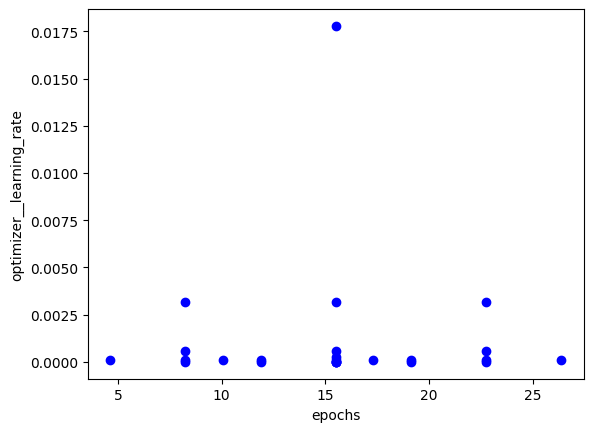

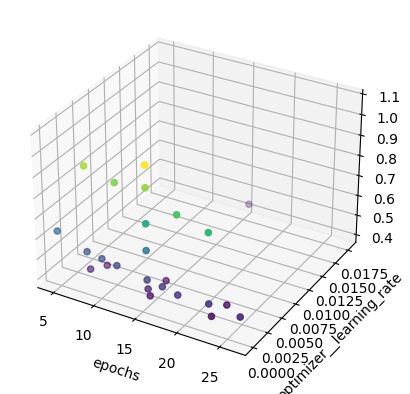

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 22.75
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.4085306443626479
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 29.999996561374893
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.37432050602651357
Resulting loss (Optimal point evaluated):
0.39685358540988225
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098, 0.3542125, 0.38245776, 0.3

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 1190.4157548908843 seconds
With Hyperparameters: 
epochs: 24.958432969348593
optimizer__learning_rate: 0.09513785933532276
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 1208320ms.


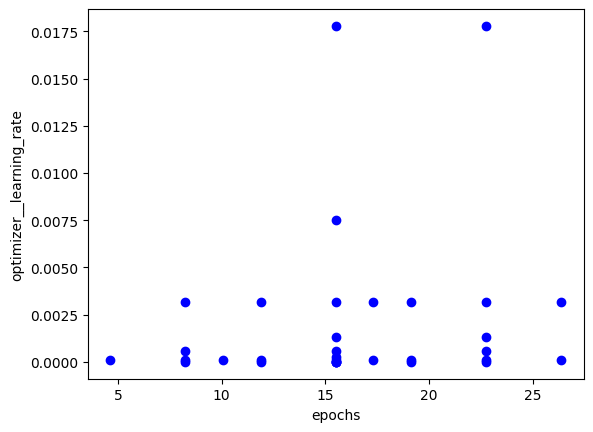

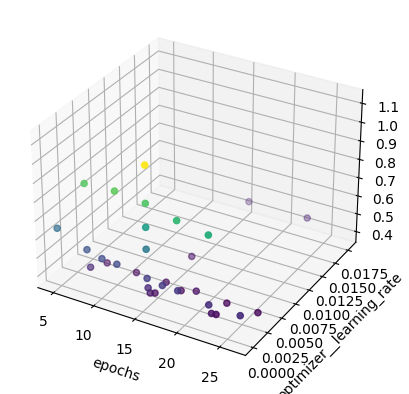

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 17.3125
optimizer__learning_rate: 0.003162277660168379
Resulting loss:
0.39273077403875434
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 17.3125
optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
0.39273077403875434
Resulting loss (Optimal point evaluated):
0.412471251950163
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873, 0.35656783]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098, 0.3542125, 0.38245776, 0

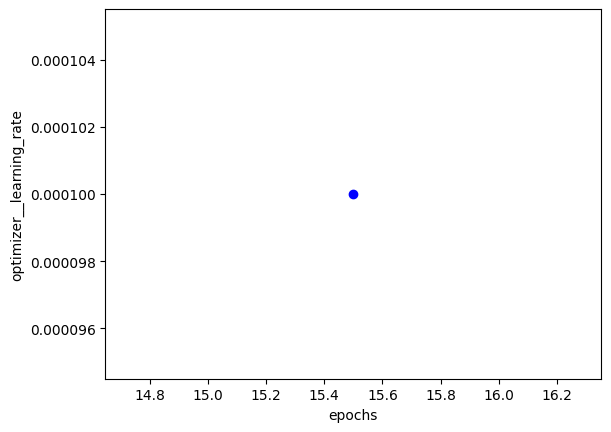

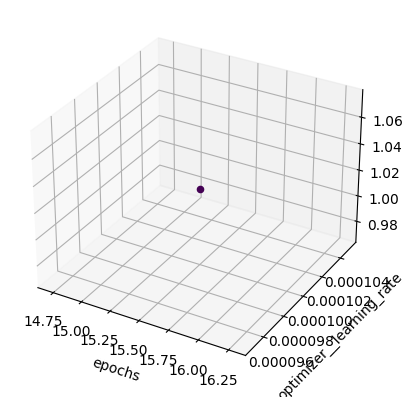

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
1.0218801508190758
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
1.0218801508190758
Resulting loss (Optimal point evaluated):
1.0290797232948732
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873, 0.35656783, 0.91529334]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098, 0.3542125, 0.3824

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 54.768460155057255 seconds
With Hyperparameters: 
epochs: 17.9557211197626
optimizer__learning_rate: 0.009436292635540966
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 16952ms.


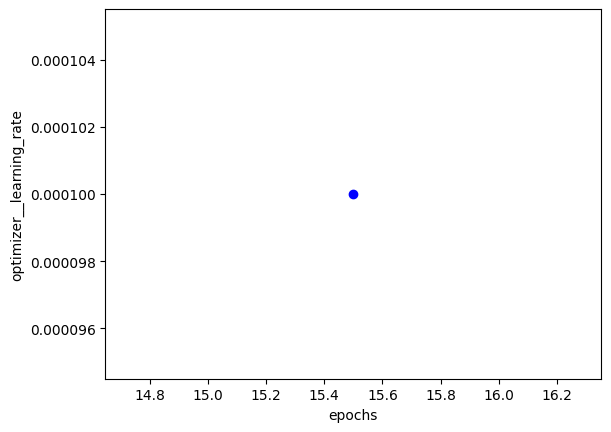

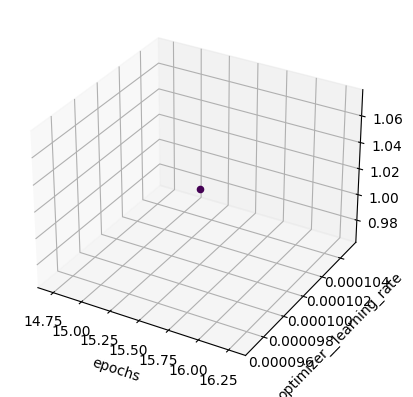

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
1.0208900248283708
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
1.0208900248283708
Resulting loss (Optimal point evaluated):
1.01311292971983
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873, 0.35656783, 0.91529334, 0.89471495]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098, 0.35421

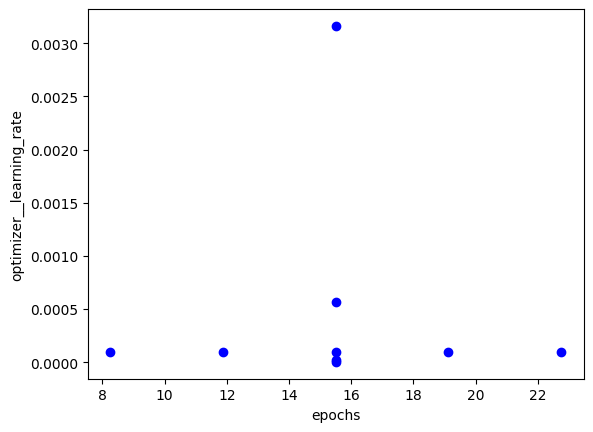

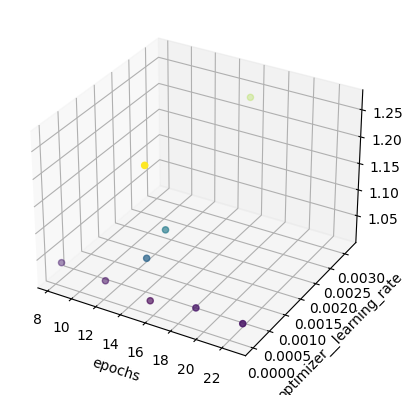

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
1.0158932958980986
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
1.0158932958980986
Resulting loss (Optimal point evaluated):
1.0273784667336625
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873, 0.35656783, 0.91529334, 0.89471495, 0.87885576]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.375

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 274.5503323680023 seconds
With Hyperparameters: 
epochs: 1.0
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 184794ms.


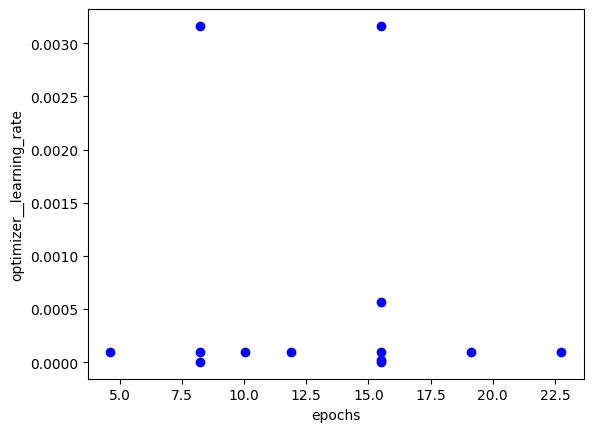

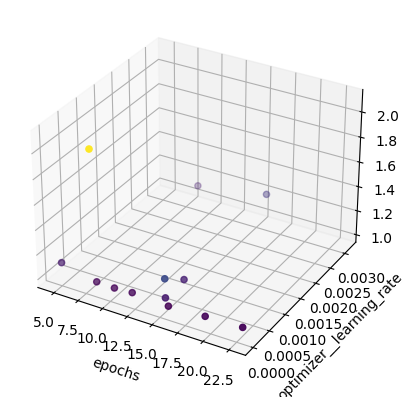

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
1.0161087086861857
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 15.5
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
1.0161087086861857
Resulting loss (Optimal point evaluated):
1.0247064515194384
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873, 0.35656783, 0.91529334, 0.89471495, 0.87885576, 0.8255186]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.625

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 487.85847711208044 seconds
With Hyperparameters: 
epochs: 26.30835358949995
optimizer__learning_rate: 0.008583774525394893
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 404596ms.


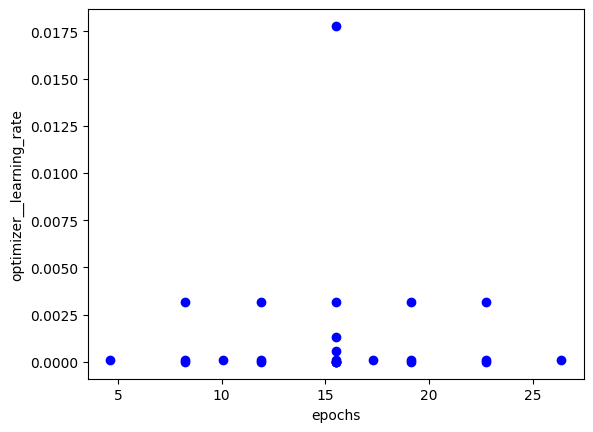

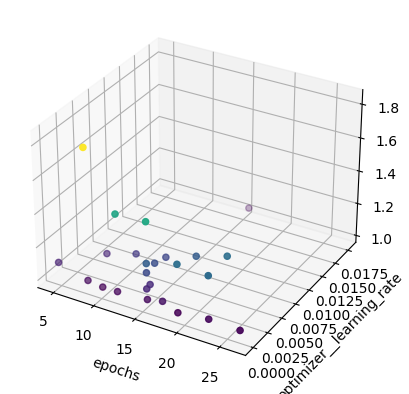

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 19.125
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
1.0156939069559847
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 19.125
optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
1.0156939069559847
Resulting loss (Optimal point evaluated):
1.0366938358761075
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873, 0.35656783, 0.91529334, 0.89471495, 0.87885576, 0.8255186, 0.7734731]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 711.9735047270078 seconds
With Hyperparameters: 
epochs: 22.361583138623754
optimizer__learning_rate: 1e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 539916ms.


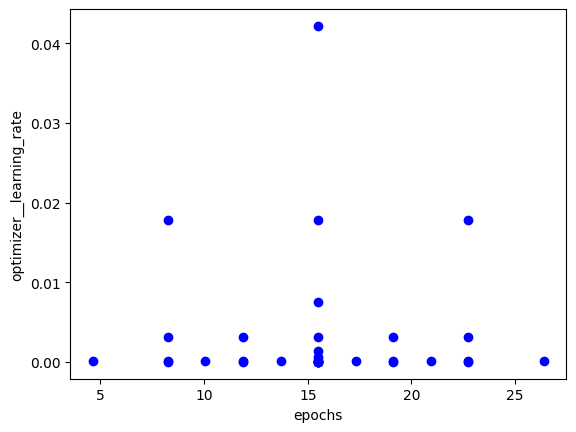

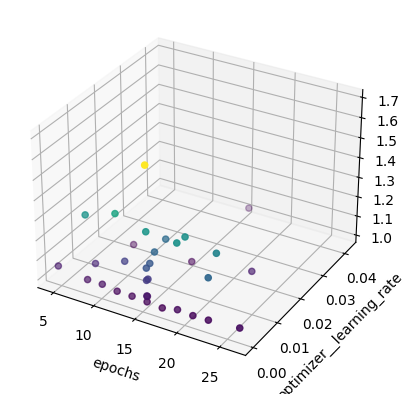

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 8.25
optimizer__learning_rate: 0.017782794100389226
Resulting loss:
1.0112946046785363
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 8.25
optimizer__learning_rate: 0.017782794100389226
Resulting loss (Optimal value from optimization):
1.0112946046785363
Resulting loss (Optimal point evaluated):
0.9871637377835479
[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873, 0.35656783, 0.91529334, 0.89471495, 0.87885576, 0.8255186, 0.7734731, 0.8206033]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.655507

In [3]:
ids = [233214, 233211, 359935, 359952, 359940]#, 359931, 317614, 359949, 359934]#, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(ratio=0.9, task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(neurons_per_layer=40, number_of_layers=1): 
        # create model
        model = Sequential()
        model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
        for _ in range(number_of_layers):
            model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    
    def evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers):
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        kfold = KFold(n_splits=CV)

        X = dataset.get_X_train().tolist() + dataset.get_X_validation().tolist()
        Y = dataset.get_Y_train().tolist() + dataset.get_Y_validation().tolist()
        
        if TESTING:
            X += dataset.get_X_test().tolist()
            Y += dataset.get_Y_test().tolist()

        X = np.array(X)
        Y = np.array(Y)

        split = (kfold.split(X, Y))

        values = []

        for i, (train_index, test_index) in enumerate(split):
            X_train = X[train_index]
            Y_train = Y[train_index]

            X_val = X[test_index]
            Y_val = Y[test_index]

            model.fit(X_train, Y_train, epochs=epochs)

            Y_predicted = model.predict(X_val)
            error = sklearn.metrics.mean_squared_error(Y_predicted, Y_val)
            values.append(error)

        result = sum(values)/len(values)
        K.clear_session()
        return result


    def blackboxfunction(params):
        #index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(params[0])

        batch_size = 1#int(params[1])

        model_learning_rate = params[1]

        neurons_per_layer = 40 # int(params[3])

        number_of_layers = 1 #int(params[4])

        return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = 3#int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[1])
            
            neurons_per_layer = 40 # int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = 1 # int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)
            

    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1)**2
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by grid search:")
            print(result.best_params_)
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        K.clear_session()

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by random search:")
            print(result.best_params_)

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = m

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " + str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        TESTING = True
        BAYESIAN_RESULT.append(blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(result[2])
        SPARSE_COST_OPTIMIZED.append(result[2])

        K.clear_session()


        print(GRID_RESULT)
        print(RANDOM_RESULT)
        print(BAYESIAN_RESULT)
        print(SPARSE_RESULT)
        print(SPARSE_RESULT_OPTIMIZED)
    


[1.2010441, 0.9886062, 1.1089722, 1.0502373, 1.0396771, 1.0990748, 0.019149624, 0.01804979, 0.017706199, 0.022180505, 0.017970063, 0.018175766, 0.644356, 0.6625699, 0.6552899, 0.66016996, 0.679167, 0.65698105, 0.3734748, 0.37428367, 0.35482997, 0.38294968, 0.38033873, 0.35656783, 0.91529334, 0.89471495, 0.87885576, 0.8255186, 0.7734731, 0.8206033]
[0.9188644, 1.0458525, 1.1112915, 1.035921, 1.0296818, 1.0457441, 0.027451275, 0.018052718, 0.020060863, 0.01861237, 0.018506397, 0.018466659, 0.7103846, 0.62846726, 0.655907, 0.6555071, 0.63717115, 0.6255769, 0.37550098, 0.3542125, 0.38245776, 0.3610055, 0.3313466, 0.36678877, 0.9745116, 0.85345, 0.7932376, 0.75719345, 0.8142086, 0.8076311]
[1.0324569457067232, 1.026758188264476, 4.774878213881888, 1.8673299544685944, 1.1009190158342972, 1.5057461512505272, 0.04328124376695806, 0.5167498780208233, 1.0055207166017492, 1.0509900948435513, 0.5314248458658408, 1.1054216450009653, 0.7104404115495565, 0.6928233513888451, 1.2194213648359966, 1.1314

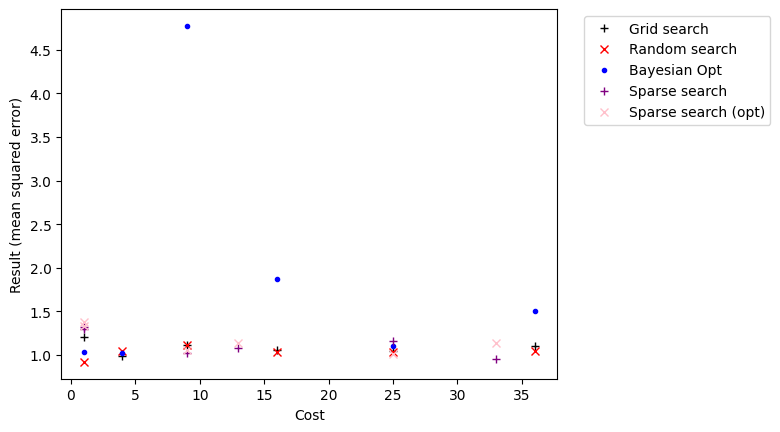

Current dataset: 1 with name id: 233211


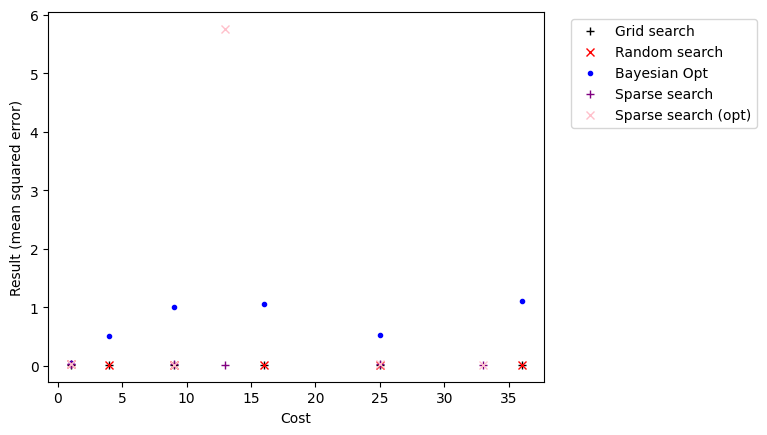

Current dataset: 2 with name id: 359935


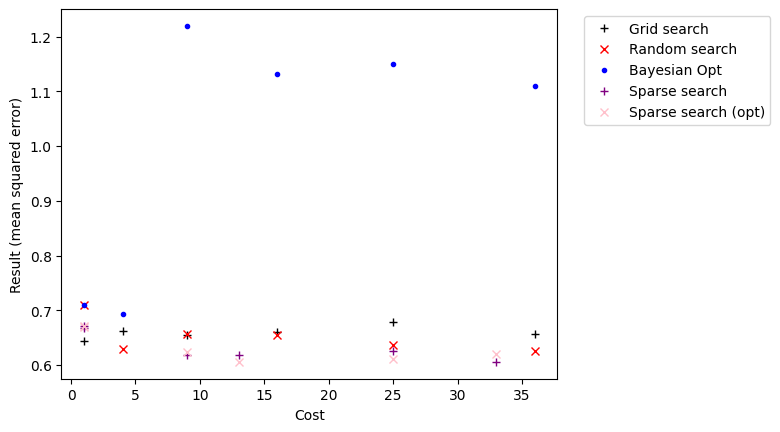

Current dataset: 3 with name id: 359952


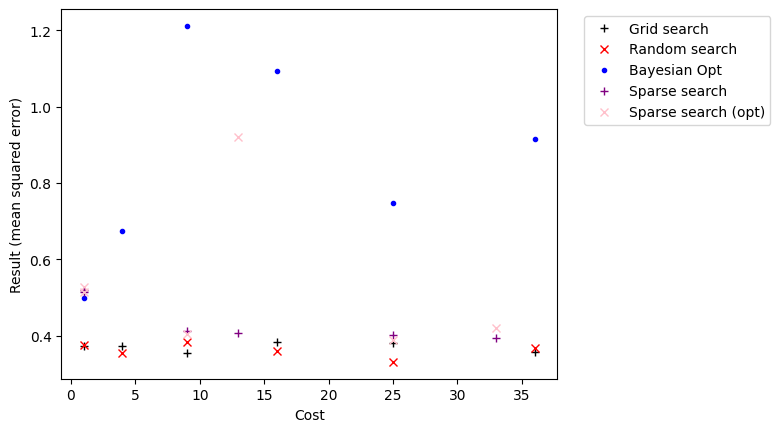

Current dataset: 4 with name id: 359940


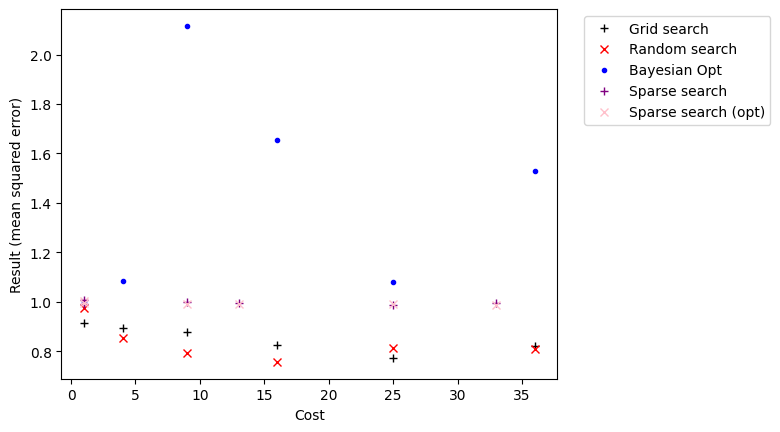

In [4]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        #plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

